In [1]:
# MLP implementation that learns multiplication of two numbers as a classification task
# Inputs: two numbers between 1-15
# Outputs: 3 numbers [X, X, X], each number stands for a digit in the multiplication result
# Eg. 8x11 = [0 8 8]

# Notes: increasing the problem complexity requires larger network size in the top layers
# Multication results that contain 3 digits require network increase from 200 neurons to 500 neurons in the top layer

In [ ]:
# TODO:
# Add normalisation
# Implement batches for evaluation

In [889]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error
from numpy import sqrt
import matplotlib.pyplot as plt
import pandas as pd
from torch.optim import lr_scheduler

from torch.utils.tensorboard import SummaryWriter

In [890]:
writer = SummaryWriter('runs/mlp_multiplication')
# run tensorboard --logdir=runs
# open localhost:6006 in browser to see tensorboard

In [891]:
# Dataset class. Prepare the dataset, normalize the inputs and targets, split into training and testing subsets

class MultiDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        # Normalize dividing input by max value so all inputs scale from 0-1
        self.x = torch.tensor(x / np.max(x), dtype=torch.float32)
        self.y = torch.tensor(y)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        variables = self.x[index]
        output1 = self.y[index][0]
        output2 = self.y[index][1]
        output3 = self.y[index][2]
        return variables, output1, output2, output3
        #return [self.x[idx], self.y[idx]]
    
    def get_splits(self, n_test = 0.33):
        test_size = round(n_test * len(self.x))
        train_size = len(self.x) - test_size
        
        return torch.utils.data.random_split(self, [train_size, test_size]) 
    
    def prepare_dataset(self):
        train, test = self.get_splits()
        train_dl = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True) # Test with larger batch numbers
        test_dl = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)
        
        return train_dl, test_dl
        

In [892]:
#for i, (inputs, target1, target2, target3) in enumerate(train_dl):
#    print(i, inputs, target1, target2, target3)

In [893]:
# Multi-layer Perceptron model with 3 hidden layers

class MLP(torch.nn.Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()        
        self.hidden1 = torch.nn.Sequential(torch.nn.Linear(n_inputs, 500), torch.nn.ReLU())
        self.hidden2 = torch.nn.Sequential(torch.nn.Linear(500, 100), torch.nn.ReLU())        
        self.hidden3 = torch.nn.Sequential(torch.nn.Linear(100, 50), torch.nn.ReLU())
        self.output1 = torch.nn.Linear(50,10)
        self.output2 = torch.nn.Linear(50,10)
        self.output3 = torch.nn.Linear(50,10)
    
    def forward(self, X):
        X = self.hidden1(X)
        X = self.hidden2(X)
        X = self.hidden3(X)
        X1 = self.output1(X)
        X2 = self.output2(X)
        X3 = self.output3(X)

        return X1, X2, X3

In [894]:
# Train the model

def train_model(train_dl, model, num_of_epochs=30):    
    criterion = torch.nn.CrossEntropyLoss()
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam optimizer performs better compared to SGD
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85) # Learning rate scheduler

    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8) # SGD optimizer
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)   

    
    error = [] # Collect errors for plotting
    lrs = []
    model.train()
    
    for epoch in range(1, num_of_epochs+1): # Train for the specified number of epochs
        for i, (inputs, target1, target2, target3) in enumerate(train_dl):
            
            optimizer.zero_grad()
            y_hat1, y_hat2, y_hat3 = model(inputs)
            #print("test", y_hat1*9, y_hat2*9)
            #print("test target", target1, target2)
            loss1 = criterion(y_hat1, target1)
            loss2 = criterion(y_hat2, target2)
            loss3 = criterion(y_hat3, target3)
            loss = loss1 + loss2 + loss3
            
            loss.backward()
            optimizer.step()
        
        writer.add_scalar('training loss', loss.item(), epoch) # write to tensorboard
        error.append(np.mean(loss.item())) 
        
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()
        
        if epoch % 5 == 0 or epoch == num_of_epochs: # Print loss at every 5th epoch
            print(f"Epoch {epoch}, Loss: {loss.item()}, LR: {optimizer.param_groups[0]['lr']:.5f}")
        
    plt.plot(error, label='Loss') 
    plt.plot(lrs, label='Lr') 
    plt.legend(loc='upper left')
    plt.xlabel('Epoch')
    plt.title('Model results')
    plt.show()

In [895]:
# Predict the output

def predict(row, model):
    row = torch.Tensor([row]) # Convert row to Torch tensor format
    row_norm = row / np.max(x) # normalise the input, change to MAX global variable
    y_hat1, y_hat2, y_hat3 = model(row_norm)
    y_hat1 = torch.argmax(y_hat1).item()
    y_hat2 = torch.argmax(y_hat2).item()
    y_hat3 = torch.argmax(y_hat3).item()
    
    result = list([str(y_hat1), str(y_hat2), str(y_hat3)])
    result = int("".join(result))
    
    return result
    

In [897]:
# Evaluate the model

def evaluate_model(test_dl, model):
    model.eval()
    predictions, actuals = list(), list()
    missed = {}
    for i, (inputs, target1, target2, target3) in enumerate(test_dl):
        
        y_hat1, y_hat2, y_hat3 = model(inputs)
        y_hat1 = torch.argmax(y_hat1).item()
        y_hat2 = torch.argmax(y_hat2).item()
        y_hat3 = torch.argmax(y_hat3).item()
        
        y_hat = list([str(y_hat1), str(y_hat2), str(y_hat3)])
        y_hat = int("".join(y_hat))
        
        actual = int(inputs[0][0].item() * np.max(x) * inputs[0][1].item() * np.max(x))
                
        predictions.append(y_hat)
        actuals.append(actual)
        
        if y_hat != actual:
            res = (int(inputs[0][0].item()*np.max(x)), int(inputs[0][1].item()*np.max(x)))
            missed[res] = y_hat
        #print(predictions[i])
        #print(actuals[i])
        
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    mse = mean_squared_error(actuals, predictions)
        
    print("MSE: %.10f, RMSE: %.10f" % (mse, sqrt(mse)))
    print("Misclassified: ")
    for d in missed:
        print(d, missed[d])


In [898]:
# Initialise the model's linear layer weights
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [899]:
# Create the dataset containing two numbers as input and multiplication result as output
sample_size = 10000
max_range = 16 #15 upper number limit 

x = []
y = []

for d in range(sample_size):
    x.append([np.random.randint(1,max_range), np.random.randint(1,max_range)]) # Trained on ranges between 0 to 15. 
    y1 = x[d][0] * x[d][1] 
    y.append(list(str(y1)))
    length = len(y[d])
    
    if length == 1:
        y[d].insert(0, '0')
        y[d].insert(0, '0')
        
    if length == 2:
        y[d].insert(0, '0')
    
    y[d] = [int(i) for i in y[d]]

x = np.array(x)
y = np.array(y)

In [900]:
# Review the dataset
index = 5
print(f"input: {x[index]}, output: {y[index]}") 

input: [12  9], output: [1 0 8]


In [901]:
dataset = MultiDataset(x, y) # Create ataset class

In [902]:
train_dl, test_dl = dataset.prepare_dataset() # Prepare dataset with train and test subsets

In [903]:
print(len(train_dl), len(test_dl)) # Check the length of training and testing batch sizes

1675 3300


In [904]:
# Create MLP model with inputs of length 2. Initialize model weights
model = MLP(2) 
init_weights(model)

In [905]:
# Add to tensorboard to visual model structure
dataiter = iter(train_dl)
train_data, label1, label2, label3 = dataiter.next()
writer.add_graph(model, train_data)
writer.close()

Epoch 5, Loss: 2.718740463256836, LR: 0.01000
Epoch 10, Loss: 1.3492908477783203, LR: 0.00500
Epoch 15, Loss: 1.0548193454742432, LR: 0.00250
Epoch 20, Loss: 0.13032600283622742, LR: 0.00250
Epoch 25, Loss: 0.07156398147344589, LR: 0.00125
Epoch 30, Loss: 0.2551110088825226, LR: 0.00063
Epoch 35, Loss: 0.0743391215801239, LR: 0.00031
Epoch 40, Loss: 0.03942646086215973, LR: 0.00031
Epoch 45, Loss: 0.013478275388479233, LR: 0.00016
Epoch 50, Loss: 0.04058409482240677, LR: 0.00008


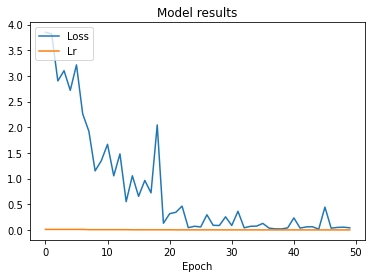

In [906]:
# Train the model for 30 epochs
train_model(train_dl, model, 50)

In [907]:
# Evaluate the model using mean square error and root mean square error
mse = evaluate_model(test_dl, model)

MSE: 0.3754545455, RMSE: 0.6127434581
Misclassified: 
(14, 15) 215
(4, 4) 15
(15, 14) 215
(13, 15) 190
(15, 13) 190


In [912]:
predict([4,4], model)

15

In [909]:
# Test learned multiplication with few random samples 
sample = []
predicted = []
actual = []
error = []

for g in range(0,10):
    sample.append(np.array([np.random.randint(1,max_range), np.random.randint(1,max_range)]))
    predicted.append(predict(sample[g], model))
    actual.append(sample[g][0] * sample[g][1])
    error.append(mean_squared_error([predicted], [actual]))
    
table = {'Input': sample, 
        'Predicted:': predicted,
        'Actual': actual,
        'Error': error
       }
pd.set_option("display.precision", 3)
df = pd.DataFrame(table)
display(df)

,Input,Predicted:,Actual,Error
0,"[6, 4]",24,24,0.0
1,"[12, 6]",72,72,0.0
2,"[13, 4]",52,52,0.0
3,"[11, 5]",55,55,0.0
4,"[9, 8]",72,72,0.0
5,"[14, 12]",168,168,0.0
6,"[12, 14]",168,168,0.0
7,"[14, 4]",56,56,0.0
8,"[2, 5]",10,10,0.0
9,"[8, 12]",96,96,0.0


In [910]:
# Manually test a sample of numbers between 1-15
x1 = 12
x2 = 13
print("%.3f " % predict(np.array([x1,x2]), model), (x1*x2))

156.000  156
